In [1]:
# Import dependencies

import numpy as np
import pandas as pd

import os

%load_ext autoreload
%autoreload 2

SEED = 42
np.random.seed(SEED)

SLIDING_WINDOW_SIZE = 10

In [2]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (17680, 10, 6)
Shape of output vector is (17680,)


In [3]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (14144, 10, 6)
Shape of y_train is (14144,)
Shape of raw_x_test is (3536, 10, 6)
Shape of y_test is (3536,)


In [4]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (14144, 80)
Shape of testing feature vector is (3536, 80)


C:\Users\tohmi\AppData\Local\Temp\ipykernel_34080\946110836.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\aten\src\ATen\native\Copy.cpp:300.)
  y_pred = model(torch.tensor(x_train).float())


Epoch 0 Loss 0.7885571718215942
Epoch 100 Loss 0.4141380786895752
Epoch 200 Loss 0.40455079078674316
Epoch 300 Loss 0.4001840651035309
Epoch 400 Loss 0.39663583040237427
Epoch 500 Loss 0.39376768469810486
Epoch 600 Loss 0.39077985286712646
Epoch 700 Loss 0.3887273967266083
Epoch 800 Loss 0.3872818052768707
Epoch 900 Loss 0.38595494627952576
Epoch 1000 Loss 0.384844571352005
Epoch 1100 Loss 0.38379931449890137
Epoch 1200 Loss 0.3828781247138977
Epoch 1300 Loss 0.3822028338909149
Epoch 1400 Loss 0.38154470920562744
Accuracy on training set is 0.9338235294117647


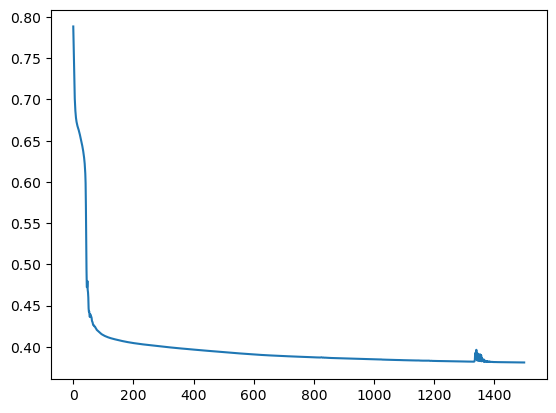

In [5]:
import torch
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [6]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9103506787330317
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1782
           1       0.92      0.90      0.91      1754

    accuracy                           0.91      3536
   macro avg       0.91      0.91      0.91      3536
weighted avg       0.91      0.91      0.91      3536

